<!-- ## Store the RPPG Result and the Graph of the Subject folders

Will store the RPPG signal (raw) and then the pre-processed one (v0.1) and the image comparasion between the GT -->

In [28]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy
import os
import scipy.signal

In [29]:
# base_model="Mediapipe-Models/blaze_face_short_range.tflite"
base_model="Mediapipe-Models/face_landmarker.task"

<!-- ## Define the POS method
Pos Method by Wenjin Wang -->

In [30]:
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]]) ## Pulse Rate Matricies
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H

In [31]:
def CHROM(signal):
    """
    CHROM method on CPU using Numpy.

    De Haan, G., & Jeanne, V. (2013). Robust pulse rate from chrominance-based rPPG. 
    IEEE Transactions on Biomedical Engineering, 60(10), 2878-2886.
    """
    X = signal
    Xcomp = 3*X[:, 0] - 2*X[:, 1]
    Ycomp = (1.5*X[:, 0])+X[:, 1]-(1.5*X[:, 2])
    sX = np.std(Xcomp, axis=1)
    sY = np.std(Ycomp, axis=1)
    alpha = (sX/sY).reshape(-1, 1)
    alpha = np.repeat(alpha, Xcomp.shape[1], 1)
    bvp = Xcomp - np.multiply(alpha, Ycomp)
    return bvp

In [32]:
def LGI(signal):
    """
    LGI method on CPU using Numpy.

    Pilz, C. S., Zaunseder, S., Krajewski, J., & Blazek, V. (2018). Local group invariance for heart rate estimation from face videos in the wild. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 1254-1262).
    """
    X = signal
    U, _, _ = np.linalg.svd(X)
    S = U[:, :, 0]
    S = np.expand_dims(S, 2)
    sst = np.matmul(S, np.swapaxes(S, 1, 2))
    p = np.tile(np.identity(3), (S.shape[0], 1, 1))
    P = p - sst
    Y = np.matmul(P, X)
    bvp = Y[:, 1, :]
    return bvp

In [33]:
def cpu_GREEN(signal):
    """
    GREEN method on CPU using Numpy

    Verkruysse, W., Svaasand, L. O., & Nelson, J. S. (2008). Remote plethysmographic imaging using ambient light. Optics express, 16(26), 21434-21445.
    """
    return signal[:,1,:]


In [34]:
def cpu_OMIT(signal):
    """
    OMIT method on CPU using Numpy.

    Álvarez Casado, C., Bordallo López, M. (2022). Face2PPG: An unsupervised pipeline for blood volume pulse extraction from faces. arXiv (eprint 2202.04101).
    """

    bvp = []
    for i in range(signal.shape[0]):
        X = signal[i]
        Q, R = np.linalg.qr(X)
        S = Q[:, 0].reshape(1, -1)
        P = np.identity(3) - np.matmul(S.T, S)
        Y = np.dot(P, X)
        bvp.append(Y[1, :])
    bvp = np.array(bvp)
    return bvp


In [35]:
# ## Create faceDetector Object
# base_options = python.BaseOptions(model_asset_path=base_model)
# FaceDetector = mp.tasks.vision.FaceDetector
# FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
# VisionRunningMode = mp.tasks.vision.RunningMode
# options = FaceDetectorOptions(
#     base_options=base_options,
#     running_mode = VisionRunningMode.IMAGE,
# )
# detector = vision.FaceDetector.create_from_options(options)

In [36]:
## Create Facelandmarker Object
base_options = python.BaseOptions(model_asset_path=base_model)
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    num_faces=1,
    running_mode = VisionRunningMode.IMAGE,
)
detector = vision.FaceLandmarker.create_from_options(options)

In [37]:
def get_cheek_rois(landmarks, image_shape):
    h, w, _ = image_shape
    left_cheek_indices = [111, 121, 50, 142]
    right_cheek_indices = [350, 340, 355, 280]

    left_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in left_cheek_indices]
    right_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in right_cheek_indices]

    left_cheek_rect = (
        min([pt[0] for pt in left_cheek_points]), min([pt[1] for pt in left_cheek_points]),
        max([pt[0] for pt in left_cheek_points]), max([pt[1] for pt in left_cheek_points])
    )
    # print("Left Cheek Rect:", left_cheek_rect)
    right_cheek_rect = (
        min([pt[0] for pt in right_cheek_points]), min([pt[1] for pt in right_cheek_points]),
        max([pt[0] for pt in right_cheek_points]), max([pt[1] for pt in right_cheek_points])
    )
    # print("Right Cheek Rect:", right_cheek_rect)

    return left_cheek_rect, right_cheek_rect


In [38]:
def extract_rgb_from_rect(rect, image):
    x_min, y_min, x_max, y_max = rect
    roi = image[y_min:y_max, x_min:x_max]
    return roi

<!-- ## Preprocessing Signal -->

In [39]:
def preprocess_ppg(signal, fs = 30):
    """ Computes the Preprocessed PPG Signal, this steps include the following:
        1. Moving Average Smoothing
        2. Bandpass Filtering
        
        Parameters:
        ----------
        signal (numpy array): 
            The PPG Signal to be preprocessed
        fs (float): 
            The Sampling Frequency of the Signal
            
        Returns:
        --------
        numpy array: 
            The Preprocessed PPG Signal
    
    """ 

    # # Moving Average Smoothing
    # window = int(fs * 0.15)  # 150ms window
    # smoothed_signal = np.convolve(signal, np.ones(window)/window, mode='same')

    # b, a = scipy.signal.butter(2, [0.5, 2.5], btype='band', fs=fs)
    # filtered = scipy.signal.filtfilt(b, a, smoothed_signal)
    
    # # Additional lowpass to remove high-frequency noise
    # b2, a2 = scipy.signal.butter(3, 2.5, btype='low', fs=fs)
    # filtered = scipy.signal.filtfilt(b2, a2, filtered)
    
    # # Moving average smoothing
    # window = int(fs * 0.15)  # 150ms window
    # filtered_signal = np.convolve(filtered, np.ones(window)/window, mode='same')

    # # Normalize the signal
    # normalized_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))


    # return normalized_signal

    b, a = scipy.signal.butter(3, [0.5, 2.5], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b, a, signal)

    return filtered



<!-- ## HRV - v0.1

Extraction the RGB Signal over the entire frame image -->

In [40]:
""" RGB Signal Variables

    Variables to store the RGB signals from the left and right cheeks,
    as well as the combined signal from both cheeks.

"""
## Utils
fs = 30 # Sampling rate in Hz for RPPG signal


# X should be increasing, y should be decreasing
# w should be decreasing, h should be decreasing to fit the box into the face

# Fixed adjustment values (in pixels)
margin_x = 10  # Adjust horizontally
scaling_factor = 0.8

<!-- ## Saving the RGB -->

In [41]:
def saving_roi_mediapipe(folders, subject_file):

    # Lists to store combined RGB values
    combined_r_signal, combined_g_signal, combined_b_signal = [], [], []

    rgb_folder = folders + "/rgb"

    # Load the video frames
    video_files = sorted(os.listdir(rgb_folder))

    # Load the face landmarks
    for i in range(len(video_files) - 1): ## The last one is
        # Load the image
        image_path = os.path.join(rgb_folder, video_files[i])
        image = cv2.imread(image_path)

        ## Detect the face area using shape
        h, w, _ = image.shape

        ## Converting into RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ## Seting up the Mediapipe Image
        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=image_rgb
        )

        # ## Get the landkmarks
        result = detector.detect(mp_image)

        # if result.detections:
        #     for detection in result.detections:

        #         ## Get the Bounding box
        #         bboxC = detection.bounding_box
        #         x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

        #         new_x = int(x + margin_x)

        #         new_w = int(w * scaling_factor)
        #         new_h = int(h * scaling_factor)

        #         ## Get the ROI
        #         face_roi = image_rgb[y:y+new_h, new_x:new_x+new_w]

        #         ## Calculate the Mean
        #         mean_rgb = cv2.mean(face_roi)[:3]
                
        #         # Append the combined RGB values to the respective lists
        #         combined_r_signal.append(mean_rgb[0])
        #         combined_g_signal.append(mean_rgb[1])
        #         combined_b_signal.append(mean_rgb[2])

        # Extract the face landmarks
        if result.face_landmarks:
            for face_landmark in result.face_landmarks:
                # Get cheek ROIs
                left_cheek_rect, right_cheek_rect = get_cheek_rois(face_landmark, image_rgb.shape)

                # Draw both cheek ROIs with rectangles
                cv2.rectangle(image_rgb, (left_cheek_rect[0], left_cheek_rect[1]), (left_cheek_rect[2], left_cheek_rect[3]), (0, 255, 0), 2)
                cv2.rectangle(image_rgb, (right_cheek_rect[0], right_cheek_rect[1]), (right_cheek_rect[2], right_cheek_rect[3]), (0, 255, 0), 2)

                # Extract the left and right cheek ROIs
                left_cheek_roi = extract_rgb_from_rect(left_cheek_rect, image_rgb)
                right_cheek_roi = extract_rgb_from_rect(right_cheek_rect, image_rgb)

                # Calculate mean pixel values for the RGB channels
                left_cheek_rgb = cv2.mean(left_cheek_roi)[:3]
                right_cheek_rgb = cv2.mean(right_cheek_roi)[:3]

                # Combine and average the RGB values from both cheeks
                combined_r = (left_cheek_rgb[0] + right_cheek_rgb[0]) / 2
                combined_g = (left_cheek_rgb[1] + right_cheek_rgb[1]) / 2
                combined_b = (left_cheek_rgb[2] + right_cheek_rgb[2]) / 2

                # Append the combined RGB values to the respective lists
                combined_r_signal.append(combined_r)
                combined_g_signal.append(combined_g)
                combined_b_signal.append(combined_b)


    ## Calculating the RPPG signal
    rgb_signals = np.array([combined_r_signal, combined_g_signal, combined_b_signal])
    rgb_signals = rgb_signals.reshape(1, 3, -1)

    ## POS
    pos_signal = POS(rgb_signals, fps=30)
    pos_signal = pos_signal.reshape(-1)

    ## CHROM
    chrom_signal = CHROM(rgb_signals)
    chrom_signal = chrom_signal.reshape(-1)

    ## LGI
    lgi_signal = LGI(rgb_signals)
    lgi_signal = lgi_signal.reshape(-1)

    ## GREEN
    green_signal = cpu_GREEN(rgb_signals)
    green_signal = green_signal.reshape(-1)

    ## OMIT
    omit_signal = cpu_OMIT(rgb_signals)
    omit_signal = omit_signal.reshape(-1)

    ## Save the RPPG as .npy
    pos_path = folders + f"/Landmark-{subject_file}-POS-rppg.npy"
    np.save(pos_path, pos_signal)

    chrom_path = folders + f"/Landmark-{subject_file}-CHROM-rppg.npy"
    np.save(chrom_path, chrom_signal)

    lgi_path = folders + f"/Landmark-{subject_file}-LGI-rppg.npy"
    np.save(lgi_path, lgi_signal)

    green_path = folders + f"/Landmark-{subject_file}-GREEN-rppg.npy"
    np.save(green_path, green_signal)

    omit_path = folders + f"/Landmark-{subject_file}-OMIT-rppg.npy"
    np.save(omit_path, omit_signal)

In [42]:
## mapping the folders
base_path=f"Physio-Itera/Dataset"

## Mapping the folders
folders=os.listdir(base_path)

## Loop the folders /rgb and /vernier
for folder in folders:
    working_folder = base_path + f"/{folder}"
    print(working_folder)
    
    ## Check if the folder is a directory
    if os.path.isdir(working_folder):
        ## Get the RGB and Vernier Folders as the path

        subject = folder
        rgb_folder = os.path.join(working_folder, "rgb")
        vernier_folder = os.path.join(working_folder, "vernier")

        ## Convert the RPPG 
        saving_roi_mediapipe(working_folder, f"{subject}")


Physio-Itera/Dataset/ades2
Physio-Itera/Dataset/ades6
Physio-Itera/Dataset/adin2
Physio-Itera/Dataset/adin6
Physio-Itera/Dataset/agus2
Physio-Itera/Dataset/agus6
Physio-Itera/Dataset/aice2
Physio-Itera/Dataset/aice6
Physio-Itera/Dataset/alana2
Physio-Itera/Dataset/alana6
Physio-Itera/Dataset/alex2
Physio-Itera/Dataset/alex6
Physio-Itera/Dataset/ali2
Physio-Itera/Dataset/ali6
Physio-Itera/Dataset/alina2
Physio-Itera/Dataset/alina6
Physio-Itera/Dataset/anggur2
Physio-Itera/Dataset/anggur6
Physio-Itera/Dataset/ara2
Physio-Itera/Dataset/ara6
Physio-Itera/Dataset/arnold2
Physio-Itera/Dataset/arnold6
Physio-Itera/Dataset/bunny2
Physio-Itera/Dataset/bunny6
Physio-Itera/Dataset/cici2
Physio-Itera/Dataset/cici6
Physio-Itera/Dataset/citra2
Physio-Itera/Dataset/citra6
Physio-Itera/Dataset/dadu2
Physio-Itera/Dataset/dadu6
Physio-Itera/Dataset/dede2
Physio-Itera/Dataset/dede6
Physio-Itera/Dataset/deka2
Physio-Itera/Dataset/deka6
Physio-Itera/Dataset/fitsan2
Physio-Itera/Dataset/fitsan6
Physio-Itera

---

### Arxiv

In [43]:
def process_gt(working_directory, subject):

    ## Load the Ground Truth
    gt_path = working_directory + f"/vernier/{subject}_vernier_ecg.csv"
    gt_ppg = pd.read_csv(gt_path, usecols=[1], header=None).values

    ## Flatten the Signal
    gt_ppg = gt_ppg.flatten()

    ## Downsample to 30Hz
    original_fs = 200
    new_fs = 30

    ## Downsampling the GT PPG Signal
    gt_ppg = scipy.signal.resample(gt_ppg, int(len(gt_ppg) * new_fs / original_fs))

    ## Preprocess the Ground Truth Signal
    gt_ppg = preprocess_ppg(gt_ppg, fs=30)
    
    ## Open the .npy files
    pos = np.load(os.path.join(working_directory, f"Landmark_{subject}-POS-rppg.npy"))
    lgi = np.load(os.path.join(working_directory, f"Landmark_{subject}-LGI-rppg.npy"))
    omit = np.load(os.path.join(working_directory, f"Landmark_{subject}-OMIT-rppg.npy"))
    green = np.load(os.path.join(working_directory, f"Landmark_{subject}-GREEN-rppg.npy"))
    chrom = np.load(os.path.join(working_directory, f"Landmark_{subject}-CHROM-rppg.npy"))

    ## Preprocess the Signals
    pos = preprocess_ppg(pos, fs=30)
    lgi = preprocess_ppg(lgi, fs=30)
    omit = preprocess_ppg(omit, fs=30)
    green = preprocess_ppg(green, fs=30)
    chrom = preprocess_ppg(chrom, fs=30)

    ## Comparing the Signals
    ## Finds the Peaks from the Preprocessed Signal and Ground Truth
    rppg_peaks, _  = scipy.signal.find_peaks(pos)
    gt_peaks, _ = scipy.signal.find_peaks(gt_ppg)

    ## Print the Peaks
    print(f"Number of Peaks in rPPG Signal: {len(rppg_peaks)}")
    print(f"Number of Peaks in Ground Truth: {len(gt_peaks)}")   

    ## Plot the Signal
    plt.figure(figsize=(20, 5)) 
    plt.plot(pos, color='black', label='rPPG Signal')
    plt.plot(rppg_peaks, pos[rppg_peaks], "x", color='red', label='rPPG Peaks')
    plt.plot(gt_ppg, color='blue', label='Ground Truth')
    plt.plot(gt_peaks, gt_ppg[gt_peaks], "x", color='green', label='Ground Truth Peaks')

    ## Adjust the text position dynamically
    y_max = max(max(pos), max(gt_ppg))  # Get the maximum y-value from both signals
    plt.text(0.02 * len(pos), y_max * 0.9, 
            f"rPPG Peaks: {len(rppg_peaks)}", color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.02 * len(gt_ppg), y_max * 0.8, 
            f"GT Peaks: {len(gt_peaks)}", color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ## Add title, labels, and legend
    plt.title('rPPG Signal vs Ground Truth')
    plt.xlabel("Samples")
    plt.ylabel('Amplitude')
    plt.legend(['rPPG Signal', 'rPPG Peaks', 'Ground Truth', 'Ground Truth Peaks'])
    
    plt.show()


In [44]:
## mapping the folders
base_path=f"PhysioItera"

## Mapping the folders
subjects=os.listdir(base_path)

## Loop the folders /rgb and /vernier
for subject in subjects:
    working_folder = base_path + f"/{subject}"
    
    process_gt(working_folder, f"{subject}")



FileNotFoundError: [Errno 2] No such file or directory: 'PhysioItera/ades2\\Landmark_ades2-POS-rppg.npy'

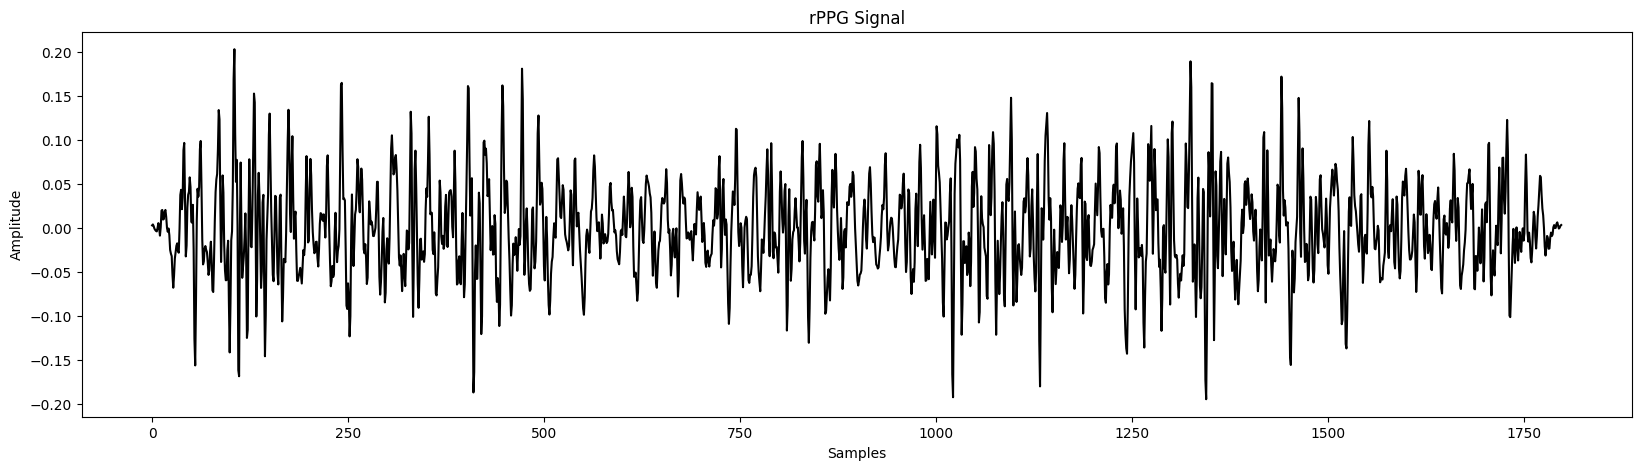

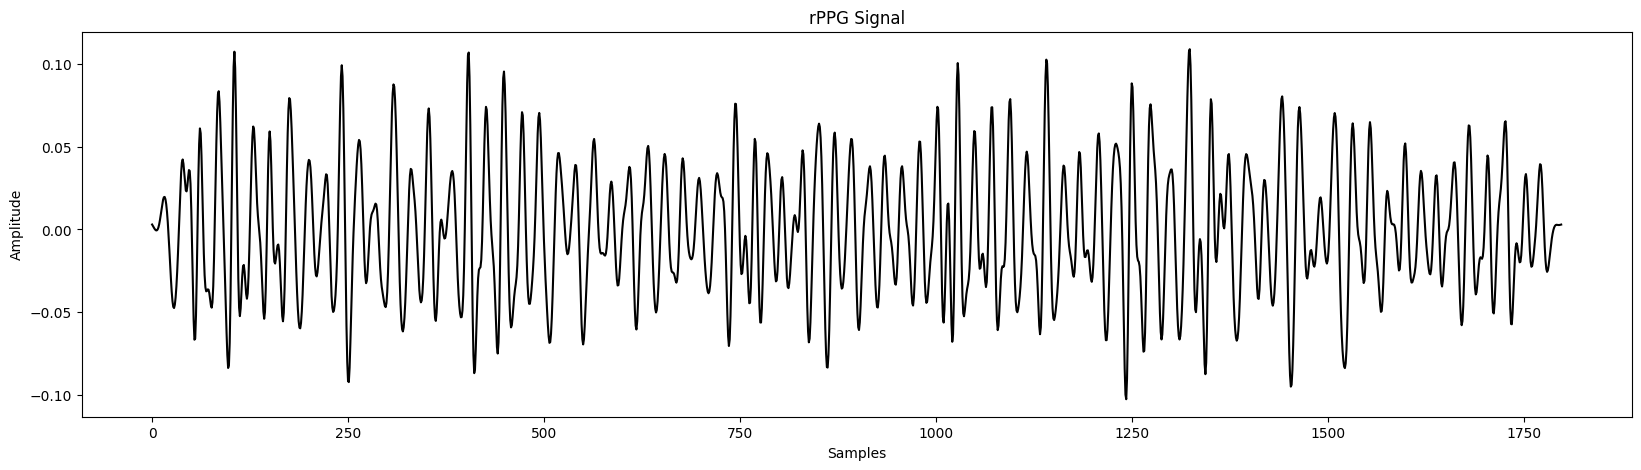

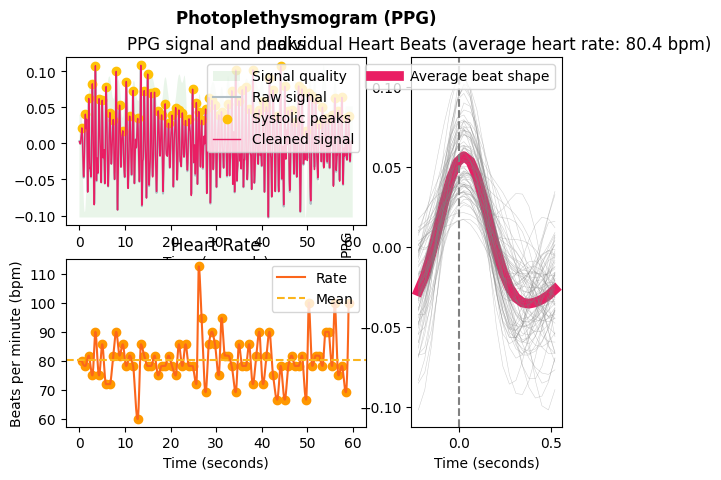

In [ ]:
## Plot the signals using the neurokit2 library

import neurokit2 as nk

# Open ades2

pos = np.load("PhysioItera/ades2/ades2-POS-rppg.npy")


gt_path = "PhysioItera/ades2" + f"/vernier/ades2_vernier_ecg.csv"
gt_ppg = pd.read_csv(gt_path, usecols=[1], header=None).values
gt_ppg = gt_ppg.flatten()   

## Process using neurokit2

signal_pos = nk.ppg_clean(pos, sampling_rate=30, method="elgendi")

## Plot the signals
plt.figure(figsize=(20, 5))
plt.plot(signal_pos, color='black', label='rPPG Signal')
plt.title('rPPG Signal')
plt.xlabel("Samples")
plt.ylabel('Amplitude')
plt.show()

signal_pos = preprocess_ppg(signal_pos, fs=30)

plt.figure(figsize=(20, 5))
plt.plot(signal_pos, color='black', label='rPPG Signal')
plt.title('rPPG Signal')
plt.xlabel("Samples")
plt.ylabel('Amplitude')
plt.show()

signal_pos, info = nk.ppg_process(signal_pos, sampling_rate=30 )

nk.ppg_plot(signal_pos, info)



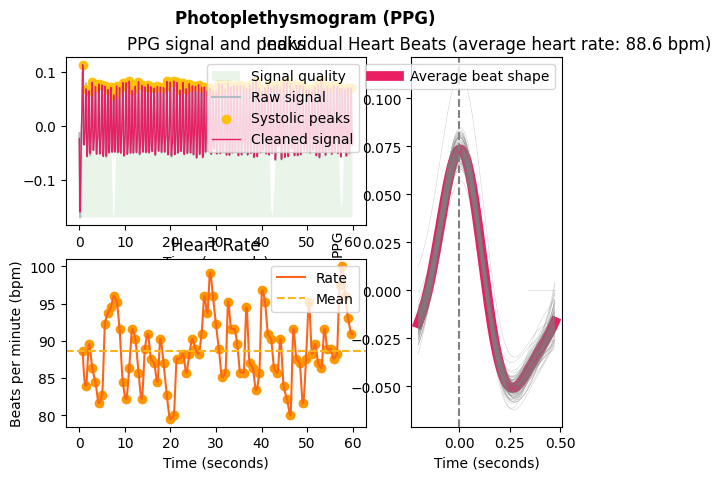

In [ ]:
gt_ppg = preprocess_ppg(gt_ppg, fs=200)

signal_gt, info = nk.ppg_process(gt_ppg, sampling_rate=200)

nk.ppg_plot(signal_gt, info)